In [1]:
import pandas as pd

In [3]:
df1 = pd.read_csv('32_Data.csv')

In [5]:
df1.shape

(89, 8)

# 개별미션 풀이

### 1번

In [6]:
from konlpy.tag import Okt

In [7]:
okt = Okt()

In [14]:
df2 = df1[['기사제목','내용']].dropna().reset_index()
text_series = df2['내용'].values.tolist()

In [15]:
# 명사만 추출 / 문장 별
df_N = pd.DataFrame()
for i in range(0, len(text_series)):
    dfn = pd.DataFrame(okt.nouns(text_series[i]))
    dfn['문장번호'] = i
    df_N = pd.concat([df_N, dfn])

In [17]:
df_N.head(3)

,0,문장번호
0,우리,0
1,정부,0
2,군함도,0


In [23]:
# 불용어 처리
df_stopword = pd.read_csv('stopword.txt') # 불용어 사전을 호출
stopword_list = df_stopword['불용어'].tolist() # 처리하기 쉽게 리스트로 변경

In [24]:
df_N

,0,문장번호
0,우리,0
1,정부,0
2,군함도,0
3,원명,0
4,하시마,0
...,...,...
1,위,82
2,김연,82
3,철,82
4,장관,82


In [26]:
import numpy as np

In [27]:
def func1(row):
    if row in stopword_list:
        return np.nan
    else:
        return row

df_N['문장명사'] = df_N[0].apply(func1)
df_N.head(10)

,0,문장번호,문장명사
0,우리,0,NaN
1,정부,0,정부
2,군함도,0,군함도
3,원명,0,원명
4,하시마,0,하시마
5,등,0,NaN
6,일본,0,일본
7,근대,0,근대
8,산업,0,산업
9,시설,0,시설


In [29]:
df_sent = df_N.dropna() # 결측값으로 처리된 불용어 단어를 제거
df_sent.head(10)

,0,문장번호,문장명사
1,정부,0,정부
2,군함도,0,군함도
3,원명,0,원명
4,하시마,0,하시마
6,일본,0,일본
7,근대,0,근대
8,산업,0,산업
9,시설,0,시설
10,곳,0,곳
12,세계,0,세계


In [33]:
# 각 문장 번호 별로 명사들이 공백(띄어쓰기)를 기준으로 나열되도록 정리
g1 = df_sent.groupby('문장번호')['문장명사'].apply(lambda x : ' '.join(x.dropna()))
df_sent2 = g1.reset_index()

In [35]:
# 유사도 분석을 위해 문장 별 리스트로 변환
text_list = df_sent2 ['문장명사'].tolist()

In [36]:
from nltk.tokenize import word_tokenize,  sent_tokenize

In [40]:
# 띄어쓰기를 기준으로 각 명사를 토큰형태로 분할
sentences1 = [word_tokenize(x) for x in text_list]

In [41]:
from gensim.models import Word2Vec

In [42]:
model_nlp = Word2Vec(sentences1, vector_size=100, window=5,
                    min_count=1, sg=1)

In [43]:
model_nlp.wv.most_similar('전략')

[('문제', 0.9971823692321777),
 ('한국', 0.9971707463264465),
 ('북한', 0.9970873594284058),
 ('정부', 0.9967448711395264),
 ('미국', 0.996694028377533),
 ('상황', 0.9966888427734375),
 ('김정은', 0.996669352054596),
 ('책임', 0.9965476989746094),
 ('대북', 0.9965229630470276),
 ('안보', 0.9964885711669922)]

In [44]:
model_nlp.wv.most_similar('자산')

[('재개', 0.9949559569358826),
 ('훈련', 0.9947832226753235),
 ('전개', 0.9944758415222168),
 ('한국', 0.99445641040802),
 ('날', 0.9944198727607727),
 ('전략', 0.9943552613258362),
 ('연합', 0.9942378401756287),
 ('북한', 0.9941690564155579),
 ('미국', 0.9940361976623535),
 ('경제', 0.9938756227493286)]

### 2번

In [45]:
df1['기사제목']

0                   정부, 유네스코에 日군함도 세계유산 취소 요구
1           "트럼프, 하노이 회담후 김정은에 北까지 데려다주겠다 제안"
2     [단독] "美北 판문점 회동때, 트럼프도 김정은도 文동행 원치 않았다"
3             [단독] "트럼프와 회담, 김정은이 아닌 정의용이 제안"
4       [단독] "트럼프 '한국 방위비 분담금' 미군철수로 위협하라 지시"
                       ...                   
84            文대통령은 NSC 불참… 통일장관은 "北도발 예고된 일"
85                         文정부 남북화해 상징이 폭파당했다
86                       [속보]개성 연락사무소 전기공급 중단
87             [속보] 軍, 대북감시 대비태세 강화.. 지휘관 정위치
88                김연철 통일부 장관 "북한의 폭파, 예고된 부분"
Name: 기사제목, Length: 89, dtype: object

In [46]:
def func2(row):
    if '단독' in row:
        return '단독'
    elif '속보' in row:
        return '속보'
    return '일반'

df1['기사유형'] = df1['기사제목'].apply(func2)
df1['기사유형'].value_counts()

기사유형
일반    80
단독     7
속보     2
Name: count, dtype: int64

In [71]:
cond1 = df1['기사유형'].isin(['단독','속보'])
text_series1 = df1.loc[cond1]['내용'].dropna().reset_index()

In [72]:
df_N2 = pd.DataFrame()
for i in range(0, len(text_series1)):
    dfn = pd.DataFrame(okt.nouns(text_series1['내용'][i]))
    df_N2 = pd.concat([df_N2, dfn])

In [76]:
p1 = df_N2[0].value_counts().head(5)

In [77]:
px.bar(p1)

In [78]:
model_nlp.wv.most_similar('대통령')

[('북한', 0.9979464411735535),
 ('청와대', 0.9977609515190125),
 ('대북', 0.9977527260780334),
 ('날', 0.9975321292877197),
 ('정부', 0.997515082359314),
 ('말', 0.9975114464759827),
 ('특사', 0.9974052309989929),
 ('안보', 0.9973689913749695),
 ('문제', 0.9972770810127258),
 ('도발', 0.9972353577613831)]

### 3번

3. '한국 경제' 신문사의 뉴스 기사 검색에서, '외교'에 해당하는 기사 20페이지를(약 180개) 수집하고, '경제'에 해당하는 기사 20페이지를 수집하여 아래와 같은 데이터 프레임을 구성하시오.
- [https://search.hankyung.com/search/news?query=외교&page=1](https://search.hankyung.com/search/news?query=%EC%99%B8%EA%B5%90&page=1)

In [79]:
from selenium import webdriver
from bs4 import BeautifulSoup
import time

In [80]:
driver = webdriver.Chrome()

In [81]:
url='https://search.hankyung.com/search/news?query=외교&page=1'
driver.get(url)

In [82]:
html1 = BeautifulSoup(driver.page_source)

In [86]:
# 첫 번째 페이지만 수집했을 때
[x.get_text() for x in html1.find_all('em', class_ = 'tit')]

["나토, '트럼프 대비' 134조원 우크라 군사지원 패키지 추진",
 '한·유엔사 국방장관회의 정례화 논의…회원국 초청행사',
 '조국당 김준형, 세 자녀 모두 미국 국적…金 "자기결정 내린 것"',
 '대통령실 "사우디와 9.6조 역대최대 수주…정상외교 결실"',
 '"사우디서 잭팟 터졌다"…삼성E&A·GS건설, 9.7조 공사 수주',
 '[속보] 대통령실 "삼성·GS, 72억弗 사우디 수주…정상외교 결실"',
 '"분노"·"규탄"…국제사회, 구호단체 오폭 이스라엘 맹비난',
 '[총선 D-7] 수도권 후보 선거공보물 뜯어보니…尹대통령·이재명 거리두기?',
 '한국환경산업기술원, 가나 사무소 개소…"아프리카 진출 거점"',
 '美中정상, 회담 4개월여만에 소통…대화 이어가며 전략경쟁 관리(종합)']

In [87]:
driver.quit()

In [90]:
# 전체 데이터 수집
driver = webdriver.Chrome()
title_list = []
url='https://search.hankyung.com/search/news?query=외교&page=1'
driver.get(url)

for i in range(2, 21):
    try:
        driver.implicitly_wait(10)
        time.sleep(1)
        html = BeautifulSoup(driver.page_source)
        get_tit = [x.get_text() for x in html1.find_all('em', class_ ='tit')]
        title_list = title_list + get_tit
    except Exception as e :
        print(e)
    finally:
        pass
    
    url_n = 'https://search.hankyung.com/search/news?query=외교&page='+str(i)
    time.sleep(1)
    driver.get(url_n)
    
driver.quit()

In [91]:
df4 = pd.DataFrame(title_list, columns=['기사제목'])
df4['분류'] = '외교'
df4

,기사제목,분류
0,"나토, '트럼프 대비' 134조원 우크라 군사지원 패키지 추진",외교
1,한·유엔사 국방장관회의 정례화 논의…회원국 초청행사,외교
2,"조국당 김준형, 세 자녀 모두 미국 국적…金 ""자기결정 내린 것""",외교
3,"대통령실 ""사우디와 9.6조 역대최대 수주…정상외교 결실""",외교
4,"""사우디서 잭팟 터졌다""…삼성E&A·GS건설, 9.7조 공사 수주",외교
...,...,...
185,"[속보] 대통령실 ""삼성·GS, 72억弗 사우디 수주…정상외교 결실""",외교
186,"""분노""·""규탄""…국제사회, 구호단체 오폭 이스라엘 맹비난",외교
187,[총선 D-7] 수도권 후보 선거공보물 뜯어보니…尹대통령·이재명 거리두기?,외교
188,"한국환경산업기술원, 가나 사무소 개소…""아프리카 진출 거점""",외교


In [ ]:
url_n = 'https://search.hankyung.com/search/news?query=경제&page='+str(i)

In [92]:
# 전체 데이터 수집
driver = webdriver.Chrome()
title_list = []
url='https://search.hankyung.com/search/news?query=경제&page=1'
driver.get(url)

for i in range(2, 21):
    try:
        driver.implicitly_wait(10)
        time.sleep(1)
        html = BeautifulSoup(driver.page_source)
        get_tit = [x.get_text() for x in html1.find_all('em', class_ ='tit')]
        title_list = title_list + get_tit
    except Exception as e :
        print(e)
    finally:
        pass
    
    url_n = 'https://search.hankyung.com/search/news?query=경제&page='+str(i)
    time.sleep(1)
    driver.get(url_n)
    
driver.quit()

In [94]:
df5 = pd.DataFrame(title_list, columns=['기사제목'])
df5['분류'] = '금융'
df5

,기사제목,분류
0,"나토, '트럼프 대비' 134조원 우크라 군사지원 패키지 추진",금융
1,한·유엔사 국방장관회의 정례화 논의…회원국 초청행사,금융
2,"조국당 김준형, 세 자녀 모두 미국 국적…金 ""자기결정 내린 것""",금융
3,"대통령실 ""사우디와 9.6조 역대최대 수주…정상외교 결실""",금융
4,"""사우디서 잭팟 터졌다""…삼성E&A·GS건설, 9.7조 공사 수주",금융
...,...,...
185,"[속보] 대통령실 ""삼성·GS, 72억弗 사우디 수주…정상외교 결실""",금융
186,"""분노""·""규탄""…국제사회, 구호단체 오폭 이스라엘 맹비난",금융
187,[총선 D-7] 수도권 후보 선거공보물 뜯어보니…尹대통령·이재명 거리두기?,금융
188,"한국환경산업기술원, 가나 사무소 개소…""아프리카 진출 거점""",금융


In [99]:
df6 = pd.concat([df4, df5])
df6.to_csv('35_Data.csv')

### 4번

4. 추출된 기사 제목에 대해, 단어 표현 유사도 분석을 실시하여, '공습'과 연관성이 높은 단어들을 추출하시오. 

In [102]:
# 불용어가 없는 데이터에 대해서만 가져오기 (이중 컴프리헨션 이용)
sent1 = [[y for y in okt.nouns(x) if y not in stopword_list] for x in df6['기사제목'].tolist()]

In [104]:
model_nlp2 = Word2Vec(sent1,  vector_size=100, window=5, min_count=1, sg=1)

In [105]:
model_nlp2.wv.most_similar('공습')

KeyError: "Key '공습' not present in vocabulary"

### 5번

In [137]:
df6['Target'] = df6['분류'].replace('외교',1).replace('금융',0)
df6['Target'].value_counts()

Target
1    190
0    190
Name: count, dtype: int64

In [138]:
df6 = df6.dropna()

In [139]:
Y = df6['Target']
X = df6['기사제목']

In [140]:
from sklearn.model_selection import train_test_split

In [141]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.3,
                                                   random_state=1234)

In [142]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [143]:
# 텍스트가 문장표현으로 처리되는 함수를 구성
def text_preprocessing(X):
    tokenizer = Tokenizer(num_words=100)
    tokenizer.fit_on_texts(X)
    seq1 = tokenizer.texts_to_sequences(X)
    return pad_sequences(seq1, maxlen=20)

In [144]:
text_preprocessing(X_train)

array([[ 0,  0,  0, ..., 34, 35, 36],
       [ 0,  0,  0, ..., 42, 43, 44],
       [ 0,  0,  0, ...,  8,  2,  3],
       ...,
       [ 0,  0,  0, ..., 71, 72, 73],
       [ 0,  0,  0, ..., 19, 20, 21],
       [ 0,  0,  0, ..., 47,  2,  3]], dtype=int32)

In [145]:
from sklearn.preprocessing import FunctionTransformer

In [146]:
text_token = FunctionTransformer(text_preprocessing)
text_token

FunctionTransformer(func=<function text_preprocessing at 0x2c71e8400>)

In [147]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [148]:
model_pipe = make_pipeline(text_token, RobustScaler(), RandomForestClassifier())
#model_pipe.fit(X_train, Y_train) # 파이프라인 작동이 잘 되는지 확인

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function text_preprocessing at 0x2c71e8400>)),
                ('robustscaler', RobustScaler()),
                ('randomforestclassifier', RandomForestClassifier())])

In [150]:
hyper_list = {'randomforestclassifier__max_depth': range(5,10),
             'randomforestclassifier__min_samples_split':[5],
             'randomforestclassifier__criterion':['gini','entropy']}
grid_model = GridSearchCV(model_pipe, param_grid=hyper_list, cv=3,
                          n_jobs=-1, scoring='accuracy')
best_model = grid_model.fit(X_train, Y_train)

In [151]:
Y_train_pred = best_model.predict(X_train)
Y_test_pred = best_model.predict(X_test)

In [152]:
from sklearn.metrics import classification_report

In [157]:
print(classification_report(Y_train, Y_train_pred))
print(classification_report(Y_test, Y_test_pred))

              precision    recall  f1-score   support

           0       0.58      0.45      0.50       132
           1       0.55      0.68      0.61       134

    accuracy                           0.56       266
   macro avg       0.57      0.56      0.56       266
weighted avg       0.57      0.56      0.56       266

              precision    recall  f1-score   support

           0       0.44      0.40      0.42        58
           1       0.44      0.48      0.46        56

    accuracy                           0.44       114
   macro avg       0.44      0.44      0.44       114
weighted avg       0.44      0.44      0.44       114



# Support Vector Machine (SVM)

- SVM 데이터를 고차원(Hyper Plane)의 공간으로 변형하여, 데이터를 분할하는 최적의 결정경계 또는 데이터를 잘 예측하는 최적의 회귀 경계를 생성
- Margins : 데이터 간의 Vector를 계산하여, 서로다른 클래스의 벡터의 면적을 이용해 결정 경계를 형성

    - X Column 데이터가 연속형 자료에 대해 비교적 잘 작동
    - 고차원의 데이터 (X Column의 개수가 많은) 에 대해서도 잘 작동
    - 비교적 적은량의 데이터(Row 개수가 적은) 대해 잘 작동
    
    - 범주형 데이터가 많은 경우에는 성능이 저하
    - 대용량 데이터에 대해 연산량이 너무 커 비효율적
    - 1000개 내외 / 100개 내 
    
- Hyper parameter
    - Cost (C) : Margin값에 들어갈 수 있는 이상치를 얼만큼 허용할 것인가
    - Cost 적게 부여 : 이상치를 많이 허용 (Overfitting 방지) -> Soft Margin
    - Cost 높게 부여 : 이상치를 최대한 적게 허용 / 모든 데이터를 Margin 밖으로 계산 (학습성능은 매우 높아짐) -> Hard Margin
    
- Kernel 기법: 데이터를 고차원 특징 공간으로 변환하여ㅕ 기존에 보이지 않는 선형분류선을 도출해 계산
    
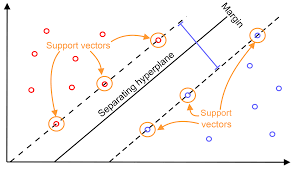

In [158]:
model_pipe2 = make_pipeline(text_token, RobustScaler(), SVC())

In [159]:
hyper_list = {'svc__C':[0.001, 0.01, 0.1, 1]}
grid_model = GridSearchCV(model_pipe2, param_grid=hyper_list,
                         scoring='f1', n_jobs=-1)
grid_model.fit(X_train, Y_train)
best_model = grid_model.best_estimator_

# RNN

- Recurrent Neural Network (RNN) 순환신경망 알고리즘 : 순서를 갖는 Sequence 데이터를 처리 / 현재까지 처리한 정보의 상태(State)를 저장하여, 앞/뒤 정보를 유지하며 학습

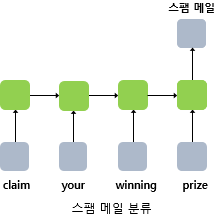

- 작동순서
    - 1. 문장 표현 Vector에서 단어가 순차적으로 Node에 들어감
    - 2. 앞서 처리된 단어의 처리결과를 활용해, 다음 Node으로 보낼 가중치를 계산(Hidden State)
    - 3. 각 단어의 위치에서 은닉층을 통과한 결과가 출력
    
- 단점 :
    - 장기 의존성 문제 (Long-Term Dependencies): 문장(Seq)가 길어지면, 이전의 정보가 점점 소실되는 현상
    - 그래디언트 소실/폭주 문제가 발생

In [160]:
from keras.layers import SimpleRNN
from keras.layers import Embedding
from keras.layers import Dense
from keras.models import Sequential

In [163]:
X_train_NN = text_preprocessing(X_train)
X_test_NN = text_preprocessing(X_test)

In [164]:
# RNN 모델 구성
model_RNN = Sequential()
model_RNN.add(Embedding(10000, 8))
model_RNN.add(SimpleRNN(32))
model_RNN.add(Dense(1, activation='sigmoid'))
model_RNN.compile(optimizer='adam', loss='binary_crossentropy',
                  metrics=['accuracy'])
model_RNN.fit(X_train_NN, Y_train, epochs=10, batch_size=32,
             validation_split=0.2)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 0.5351 - loss: 0.6938 - val_accuracy: 0.4630 - val_loss: 0.6992
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5817 - loss: 0.6845 - val_accuracy: 0.4630 - val_loss: 0.7030
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5849 - loss: 0.6805 - val_accuracy: 0.4630 - val_loss: 0.7095
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5808 - loss: 0.6790 - val_accuracy: 0.4630 - val_loss: 0.7151
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5440 - loss: 0.6784 - val_accuracy: 0.4444 - val_loss: 0.7202
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5438 - loss: 0.6700 - val_accuracy: 0.4444 - val_loss: 0.7258
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.6288 - loss: 0.6614 - val_accuracy: 0.4815 - val_loss: 0.7294
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5853 - loss: 0.6683 - val_accuracy: 0.4815 - val_loss: 0.7295
Epoc

In [167]:
def threshold(result):
    if result >= 0.5:
        return 1
    return 0

In [168]:
model_RNN.predict(X_train_NN)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step


array([[0.31354114],
       [0.42323697],
       [0.59322137],
       [0.31354114],
       [0.63247985],
       [0.63247985],
       [0.59322137],
       [0.63247985],
       [0.4796432 ],
       [0.5004327 ],
       [0.63247985],
       [0.5004327 ],
       [0.63247985],
       [0.63247985],
       [0.5004327 ],
       [0.57732654],
       [0.60742587],
       [0.4796432 ],
       [0.5004327 ],
       [0.59322137],
       [0.59322137],
       [0.4796432 ],
       [0.5004327 ],
       [0.31354114],
       [0.42323697],
       [0.42323697],
       [0.57732654],
       [0.57732654],
       [0.49995986],
       [0.60742587],
       [0.59322137],
       [0.57732654],
       [0.49995986],
       [0.59322137],
       [0.42323697],
       [0.60742587],
       [0.42323697],
       [0.31354114],
       [0.63247985],
       [0.60742587],
       [0.59322137],
       [0.57732654],
       [0.4796432 ],
       [0.59322137],
       [0.60742587],
       [0.3840332 ],
       [0.59322137],
       [0.593

In [171]:
Y_train_pred = pd.Series(model_RNN.predict(X_train_NN).flatten()).apply(threshold)
Y_test_pred = pd.Series(model_RNN.predict(X_test_NN).flatten()).apply(threshold)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step


In [172]:
print(classification_report(Y_train, Y_train_pred))
print(classification_report(Y_test, Y_test_pred))

              precision    recall  f1-score   support

           0       0.56      0.54      0.55       132
           1       0.56      0.58      0.57       134

    accuracy                           0.56       266
   macro avg       0.56      0.56      0.56       266
weighted avg       0.56      0.56      0.56       266

              precision    recall  f1-score   support

           0       0.53      0.71      0.61        58
           1       0.54      0.36      0.43        56

    accuracy                           0.54       114
   macro avg       0.54      0.53      0.52       114
weighted avg       0.54      0.54      0.52       114



### 6번

6. '33_Data.xlsx' 데이터를 불러와, 생성한 모델에 넣어 '외교'와 '금융'항목을 분류하시오.

In [175]:
df7 = pd.read_excel('33_Data.xlsx')

In [176]:
input_data = text_preprocessing(df7['기사제목'])

In [183]:
pred = pd.Series(model_RNN.predict(input_data).flatten()).apply(threshold)
df7['기사분류'] = pred.replace({0:'경제', 1:'외교'})
df7['기사분류'].value_counts()

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step


기사분류
경제    512
외교    168
Name: count, dtype: int64

In [184]:
df7

,Unnamed: 0,기사제목,기사분류
0,0,주 52시간 준법투쟁에 불꺼진 병동…수술실서 사라진 의대교수들,경제
1,1,반도체發 봄바람에 수출 훈풍 계속…'침체기 효자'였던 車수출↓,경제
2,2,[테샛 공부합시다] 日 가격 · 中 기술에도 쫓기는 산업경쟁력,경제
3,3,"끊임없이 디플레이션에 시달리는 중국 경제…시진핑 주석, 과연 해결책은 있나 [국제경...",경제
4,4,"뉴욕증시, 고용 지표·테슬라 1분기 출하량 주목 [출근전 꼭 글로벌브리핑]",경제
...,...,...,...
675,675,"IMF, '경제난' 파키스탄에 구제금융 7억달러 추가 지급 승인",경제
676,676,尹대통령 경제 행보에 매일 아침 '경제 스터디'하는 참모들,경제
677,677,"IMF ""올해 세계 경제 성장세 유지하지만 작년보다 둔화""",외교
678,678,"'집단학살'혐의 이스라엘 국제법정에…팔 감격 ""그 자체로 승리""",경제


# LSTM (Long Short Term Memory)

- RNN 모델의 장기의존성 문제를 해결하기 위해 고안된 RNN 모델

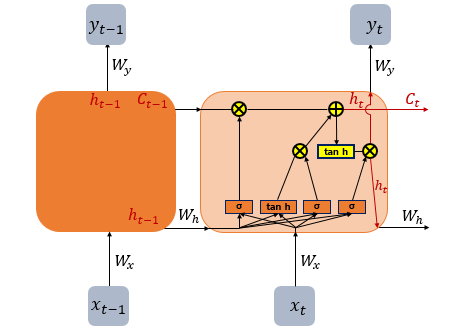

- RNN 모델에 시퀀스의 길이가 긴 데이터에 대하여, Cell State라는 Node를 이용하여, 장기적으로 정보가 전달될 수 있도록 계산
- LSTM 모델은 Cell State를 조정하기 위해, 세 가지 Gate를 사용
    - 1. Input Gate : Cell State에 새로운 정보를 추가할지 결정
        - 하나는 시그모이드 함수를 이용해, 어떤 값을 업데이트 할건지 결정
        - 하나는 탄젠트 함수를 사용하여 Cell State에 추가될 후보 값들을 생성
        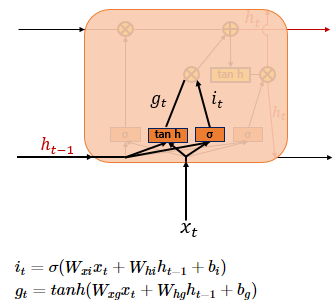
    - 2. Forget Gate : Cell State에서 어떤 정보를 제거할 지 결정
        - 시그모이드 함수를 통해 1,0 값으로 결과를 계산 / 1값이면 정보를 유지 / 0 값이면 정보를 삭제
        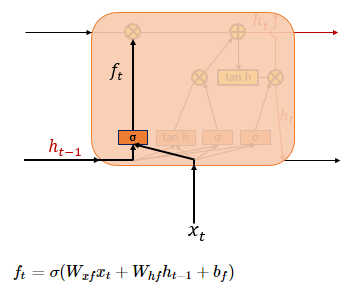
    - 3. Output Gate : Cell State를 기반으로 어떤 정보를 출력할지 결정
        - 시그모이드 함수를 이용해, 어떤 정보를 출력할지 결정하고, 탄젠트 함수를 활용해 출력값을 -1값과 1사이로 출력을 수행
        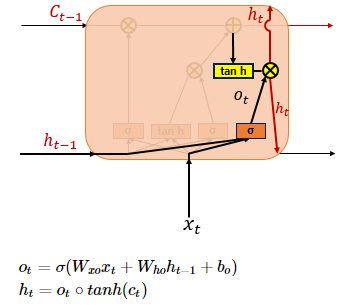

In [185]:
from keras.layers import LSTM

- Dropout (드롭아웃) : 신경망을 학습할 때, 과적합(Overfitting)을 방지하는 규제
- 훈련 과정에서 각 배치를 처리할 때 마다 개별 노드가 일정 확률로 활성/비활성

In [186]:
model_LSTM = Sequential()
model_LSTM.add(Embedding(10000,8))
model_LSTM.add(LSTM(128, dropout=0.2))
model_LSTM.add(Dense(1, activation='sigmoid'))
model_LSTM.compile(optimizer='adam', loss='binary_crossentropy',
                   metrics=['accuracy'])
model_LSTM.fit(X_train_NN, Y_train, epochs=10, batch_size= 32,
               validation_split=0.2)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 177ms/step - accuracy: 0.5278 - loss: 0.6931 - val_accuracy: 0.4630 - val_loss: 0.6961
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5075 - loss: 0.6930 - val_accuracy: 0.4630 - val_loss: 0.6948
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4846 - loss: 0.6937 - val_accuracy: 0.4630 - val_loss: 0.6945
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5387 - loss: 0.6913 - val_accuracy: 0.4630 - val_loss: 0.6955
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5837 - loss: 0.6888 - val_accuracy: 0.4630 - val_loss: 0.6971
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5649 - loss: 0.6875 - val_accuracy: 0.4630 - val_loss: 0.6993
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5194 - loss: 0.6916 - val_accuracy: 0.5000 - val_loss: 0.6984
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5266 - loss: 0.6867 - val_accuracy: 0.4630 - val_loss: 0.7047

In [187]:
Y_train_pred = pd.Series(model_LSTM.predict(X_train_NN).flatten()).apply(threshold)
Y_test_pred = pd.Series(model_LSTM.predict(X_test_NN).flatten()).apply(threshold)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [188]:
print(classification_report(Y_train, Y_train_pred))
print(classification_report(Y_test, Y_test_pred))

              precision    recall  f1-score   support

           0       0.55      0.65      0.60       132
           1       0.58      0.47      0.52       134

    accuracy                           0.56       266
   macro avg       0.56      0.56      0.56       266
weighted avg       0.56      0.56      0.56       266

              precision    recall  f1-score   support

           0       0.48      0.52      0.50        58
           1       0.45      0.41      0.43        56

    accuracy                           0.46       114
   macro avg       0.46      0.46      0.46       114
weighted avg       0.46      0.46      0.46       114



# GRU (Gated Recurrent Unit)

- LSTM 모델의 변형으로 LSTM 모델보다 구조가 더 간단하여, 빠르고 효율적인 계산이 가능한 신경망 알고리즘
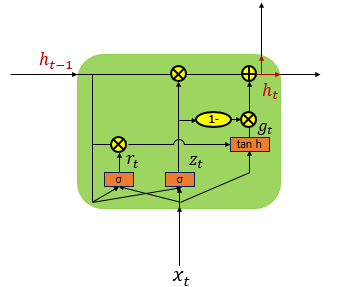
- GRU 모델은 LSTM의 셀 상태 (CEll state)와 Output Gate를 제거하고, 두 가지 게이트만 이용하여, 연산
    - Update Gate : 현재의 Hidden State가 다음 Hidden State에 얼마나 반영될 지를 결정 / LSTM에서 입력게이트와 삭제게이트의 역할 / 과거의 정보를 얼마나 유지할지를 결정하는 정보값이 계산
    - Reset Gate : 이전의 Hidden State 현재의 입력과 함께 어떻게 결합될 지를 결정 / LSTM 의 Cell State의 역할 수행 / 과거의 정보를 효과적으로 필터링 해내는데 사용
    
- LSTM 모델과 비교했을 때, 더 적은 항목(Columns) 있는 데이터에 대해 잘 작동

In [189]:
from keras.layers import GRU

In [191]:
model_GRU = Sequential()
model_GRU.add(Embedding(10000,8))
model_GRU.add(GRU(32))
model_GRU.add(Dense(1, activation='sigmoid'))
model_GRU.compile(optimizer='adam', loss='binary_crossentropy',
                  metrics=['accuracy'])
model_GRU.fit(X_train_NN, Y_train, epochs=10, batch_size=32,
              validation_split=0.3)

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 211ms/step - accuracy: 0.4475 - loss: 0.6937 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4854 - loss: 0.6940 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5134 - loss: 0.6923 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5207 - loss: 0.6923 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5828 - loss: 0.6904 - val_accuracy: 0.5000 - val_loss: 0.6929
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5563 - loss: 0.6900 - val_accuracy: 0.5125 - val_loss: 0.6927
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5051 - loss: 0.6926 - val_accuracy: 0.5375 - val_loss: 0.6926
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5743 - loss: 0.6883 - val_accuracy: 0.5375 - val_loss: 0.6925
Epoch 

In [192]:
Y_train_pred = pd.Series(model_GRU.predict(X_train_NN).flatten()).apply(threshold)
Y_test_pred = pd.Series(model_GRU.predict(X_test_NN).flatten()).apply(threshold)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [193]:
print(classification_report(Y_train, Y_train_pred))
print(classification_report(Y_test, Y_test_pred))

              precision    recall  f1-score   support

           0       0.58      0.45      0.50       132
           1       0.55      0.68      0.61       134

    accuracy                           0.56       266
   macro avg       0.57      0.56      0.56       266
weighted avg       0.57      0.56      0.56       266

              precision    recall  f1-score   support

           0       0.50      0.47      0.48        58
           1       0.48      0.52      0.50        56

    accuracy                           0.49       114
   macro avg       0.49      0.49      0.49       114
weighted avg       0.49      0.49      0.49       114



----

# 개별미션

- 아래의 미션을 Jupyter Notebook으로 풀이 후, [File] - [Download as]에 [HTML (.html] 로 저장하여 메일로 송부해주세요.
- 제출 양식 : [하나은행_데이터] 홍길동_개별 미션 (12주차 3일)

- '34_Data.xlsx' 파일을 불러와 아래의 분석을 수행하시오.
- 해당 데이터는 2011년도부터 2013년도까지 국내 기업의 신용 대출 관련 데이터이다.
- 업력의 단위는 연도 이며, 자본금과 대출금액 단위는 백만원이다.
- 진행상태는 대출 승인 여부를 나타내며, 여신 승인은 대출 승인, 여신 거부는 대출 거부를 뜻한다.

In [262]:
from collections import Counter

In [263]:
df1 = pd.read_excel('34_Data.xlsx')

1. 대출 승인이 된 기업 중, 자본금이 가장 많은 100개 기업에 대하여 추출하고, 해당 기업의 기술명 중 가장 빈도수가 높은 단어를 확인하시오.

In [264]:
df1['진행상태'].value_counts()

진행상태
여신승인    1628
여신거부     385
투자연계       2
Name: count, dtype: int64

In [265]:
df2 = df1[df1['진행상태']=='여신승인']

In [266]:
top_100_companies = df2.nlargest(100, '자본금')

In [267]:
all_technologies = ' '.join(top_100_companies['기술명'])

In [268]:
Counter(all_technologies.split())

Counter({'및': 23,
         '개발': 18,
         '기술': 16,
         '제조': 15,
         '이용한': 7,
         '사업': 6,
         '제작': 5,
         '시스템': 4,
         '통한': 4,
         '가공': 4,
         '솔루션': 3,
         '친환경': 3,
         'LCD': 3,
         '장치': 3,
         '서비스': 3,
         '플랫폼': 3,
         '패널': 3,
         '설계': 3,
         '시멘트': 2,
         '조성물': 2,
         '부품': 2,
         '위한': 2,
         '포함한': 2,
         '자동차용': 2,
         '제품': 2,
         '기능성': 2,
         '제작기술': 2,
         '글로벌': 2,
         '개발을': 2,
         '교육': 2,
         '모듈': 2,
         '차량용': 2,
         '기반': 2,
         '제조방법': 2,
         '분쇄': 2,
         'PIPE': 2,
         '생산': 2,
         '송전선': 2,
         '가지는': 2,
         '스크린': 2,
         '패키지': 2,
         '지능형': 2,
         '보안': 2,
         '저발열': 1,
         '저수축': 1,
         '선박용': 1,
         '위성통신': 1,
         '안테나': 1,
         '경유': 1,
         '차량의': 1,
         'CNG': 1,
         '전소': 1,
         'LNG': 1,
       

----

2. 기업의 설립일을 이용해, 기업의 업력 (설립 후 현재까지 지속된 기간 / 연도)을 계산하고, 대출 승인여부에 따른 기업 업력의 대표값의 차이가 있는지 검정하시오.

In [269]:
import numpy as np
import plotly.express as px
import scipy.stats as stats

In [270]:
df1['설립일_dt'] = pd.to_datetime(df1['설립일'])

In [271]:
current_date = pd.to_datetime('now')

In [272]:
def func2(establishment):
    term = (current_date - establishment).days / 365
    return term

In [273]:
df1['업력'] = df1['설립일_dt'].apply(func2)

In [274]:
cond1 = (df1['진행상태']=='여신승인')

a1 = df1.loc[cond1]
a2 = df1.loc[~cond1]

In [275]:
# 귀무 가설 : 대출 승인여부에 따른 기업 업력의 대표값의 차이가 없다
# 대립 가설 : 대출 승인여부에 따른 기업 업력의 대표값의 차이가 있다

stats.ranksums(a1['업력'], a2['업력'])

# P.value< 0.05/ 대립가설 참
# 대출 승인여부에 따른 기업 업력의 대표값의 차이가 있다

RanksumsResult(statistic=3.609735172635461, pvalue=0.0003065097757821546)

---

3. 기업 평가등급과 대출 승인여부의 유의미한 차이가 있는지 가설 검정을 수행하고, 대출 승인 비율을 각 평가 등급 별로 계산하시오.

In [276]:
df1 = df1[df1['진행상태']!='투자연계']

In [277]:
# 두 범주형 데이터 -> 서로 연관성 있는지? (독립성 검정)

In [278]:
df1_cross = pd.crosstab(df1['평가등급'], df1['진행상태'])
df1_cross

진행상태,여신거부,여신승인
평가등급,,
A,53,238
AA,14,66
AAA,0,2
B,108,429
BB,91,461
BBB,94,428
C,1,0
CCC,2,1
T1,0,1


In [279]:
# 독립성 검정 (Chi2 Test)
# 귀무가설 : 두 데이터는 서로 독립이다. (기업평가등급에 따라 승인여부의 비율이 같을것)
# 대립가설 : 두 데이터는 서로 연관성 있다.(기업평가등급에 따라 승인여부의 비율이 같을것 달라짐)
stats.chi2_contingency(df1_cross)[1]
# P.value < 0.05 / 대립가설 참 / 두 데이터는 서로 연관성 있다

2.272613518043929e-14

---

4. 여신승인 된 기업 중, 자본금과 대출금액의 합이 가장 높은 10개 기업을 확인하시오.

In [280]:
df2 = df1[cond1]

/var/folders/q9/51yx3nc91mq6crjc81y6g1wm0000gn/T/ipykernel_43751/1691022724.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [281]:
df2.columns

Index(['회사명', '기술명', '기술분류', '설립일', '신청일', '평가기관', '평가등급', '신청은행', '진행상태',
       '대출금액', '자본금', '설립일_dt', '업력'],
      dtype='object')

In [282]:
df2['자본금'].isnull().sum()

0

In [283]:
df2['대출금액'].isnull().sum()

0

In [284]:
df2['자본금'] = pd.to_numeric(df2['자본금'], errors='coerce')
df2['대출금액'] = pd.to_numeric(df2['대출금액'], errors='coerce')

/var/folders/q9/51yx3nc91mq6crjc81y6g1wm0000gn/T/ipykernel_43751/1631122960.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/q9/51yx3nc91mq6crjc81y6g1wm0000gn/T/ipykernel_43751/1631122960.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [285]:
df2['자본금및대출금액'] = df2['자본금'] + df2['대출금액']

/var/folders/q9/51yx3nc91mq6crjc81y6g1wm0000gn/T/ipykernel_43751/413764685.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [286]:
df2.nlargest(10, '자본금및대출금액')['회사명']

1691    엔프로그기공
447     클로벳모터스
1494    엔프로그물산
1943     텍틱스제약
1802    슈터스모터스
1527     하나로무역
767       DS제약
1410    세계로연구소
1468     투비원제약
1318     포텐셜기공
Name: 회사명, dtype: object

----

5. 기술 분류에 '기계'에 해당하는 기업의 기술명을 단어표현을 통해, '반도체'라는 단어와 가장 유사한 단어들이 무엇이 있는지 확인하시오.

In [290]:
df3 = df1[df1['기술분류']=='기계']

In [291]:
df3.columns

Index(['회사명', '기술명', '기술분류', '설립일', '신청일', '평가기관', '평가등급', '신청은행', '진행상태',
       '대출금액', '자본금', '설립일_dt', '업력'],
      dtype='object')

In [292]:
from gensim.models import Word2Vec

In [293]:
words = [tech.split() for tech in df3['기술명']]

In [294]:
model = Word2Vec(words, min_count=1, sg=1)

In [295]:
model.wv.most_similar('반도체')

[('자동차', 0.34949690103530884),
 ('파쇄', 0.33571964502334595),
 ('하드코어', 0.32631921768188477),
 ('칼라', 0.3222261965274811),
 ('생산공정', 0.2928478717803955),
 ('제조용', 0.27477023005485535),
 ('발전기', 0.2701660096645355),
 ('생산기', 0.25587841868400574),
 ('헤드라이닝', 0.2554756999015808),
 ('BEAM', 0.25113025307655334)]

---

6. 대출금액을 가장 많이 집행한 은행을 확인하고, 해당 은행이 어떤 기술분류에 대출금액을 가장 많이 집행했는지 계산하시오.

In [297]:
df1.columns

Index(['회사명', '기술명', '기술분류', '설립일', '신청일', '평가기관', '평가등급', '신청은행', '진행상태',
       '대출금액', '자본금', '설립일_dt', '업력'],
      dtype='object')

In [299]:
df1['대출금액'] = pd.to_numeric(df1['대출금액'], errors='coerce')

In [303]:
df1.groupby('신청은행')['대출금액'].sum().sort_values(ascending=False).head(1)

신청은행
기업은행    104876.0
Name: 대출금액, dtype: float64

In [306]:
ex6 = df1[df1['신청은행'] == '기업은행']

In [308]:
ex6.groupby('기술분류')['대출금액'].sum().idxmax()

'기계'

---

7. '기술보증기금' 평가 기관에서 집행한 대출금액에 대한 합을 일별로 계산해, 기술 분류에 따라 나누어 시각화 하시오.

In [321]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'AppleGothic'

In [311]:
df7 = df1[df1['평가기관']=='기술보증기금']

In [316]:
df7['신청일_dt'] = pd.to_datetime(df7['신청일']).dt.date

/var/folders/q9/51yx3nc91mq6crjc81y6g1wm0000gn/T/ipykernel_43751/2890781117.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [317]:
df7.groupby('신청일_dt')['대출금액'].sum()

신청일_dt
2011-02-22    1340.0
2011-02-23    1850.0
2011-02-24    2329.0
2011-02-25     410.0
2011-02-28    1975.0
               ...  
2013-12-12       0.0
2013-12-13       0.0
2013-12-16      30.0
2013-12-18       0.0
2013-12-23       0.0
Name: 대출금액, Length: 404, dtype: float64

In [319]:
ex7 = df7.groupby(['신청일_dt', '기술분류'])['대출금액'].sum().unstack()

<Axes: xlabel='신청일_dt'>

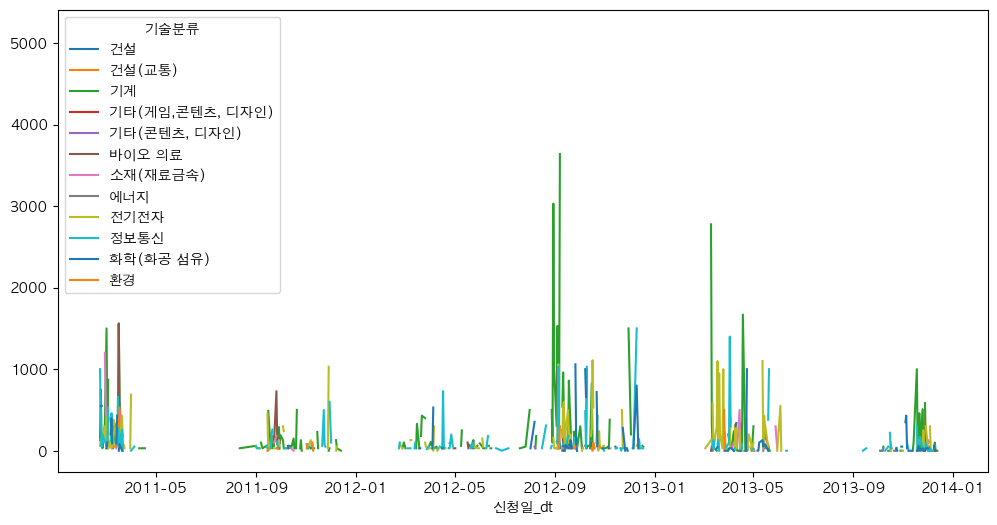

In [323]:
ex7.plot(kind='line', figsize=(12, 6))

---

8. '바이오 의료' 관련 기술을 가진 기업의 기술명에 대한 워드클라우드를 시각화 하시오.

In [328]:
df8 = df1[df1['기술분류']=='바이오 의료']

In [331]:
text = ' '.join(df8['기술명'])

In [332]:
from wordcloud import WordCloud

In [334]:
wordcloud = WordCloud(font_path='AppleGothic',
                       background_color='white').generate(text)

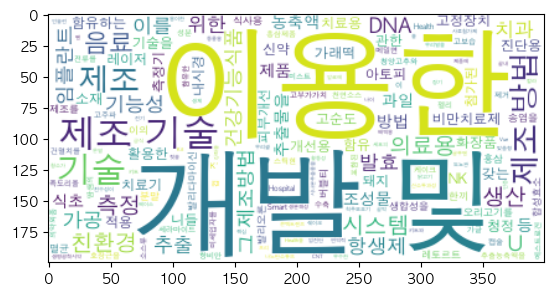

In [336]:
plt.imshow(wordcloud, interpolation='bilinear')

----

9. 기술명과 대출금액, 기술분류, 신청은행, 자본금을 입력했을 때, 대출 승인 여부를 판별하는 모델을 Scikit Learn라이브러리를 활용해 구성하시오.

In [337]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [342]:
df1['자본금'] = pd.to_numeric(df1['자본금'], errors='coerce')

In [390]:
df1['대출승인여부'] = df1['진행상태'].apply(lambda x: 1 if x == '여신승인' else 0)

In [393]:
X = df1[['기술명', '대출금액', '기술분류', '신청은행', '자본금']]
Y = df1['대출승인여부']

In [394]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,
                                                   test_size=0.3, random_state=1234)

In [398]:
numeric_list = X.describe().columns
category_list = X.describe(include='object').columns

In [407]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from imblearn.pipeline import make_pipeline
from sklearn.compose   import make_column_transformer
from sklearn.impute    import KNNImputer
from sklearn.impute    import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from imblearn.combine  import SMOTETomek
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer

In [408]:
numeric_pipe = make_pipeline(SimpleImputer(strategy='median'),
                            MinMaxScaler())
category_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'),
                             OneHotEncoder(handle_unknown='ignore'))

In [409]:
prepropipe = make_column_transformer((numeric_pipe, numeric_list),
                                     (category_pipe, category_list))

In [418]:
pipe_model = make_pipeline(prepropipe, RandomForestClassifier())

In [419]:
hyperparameter = {'randomforestclassifier__n_estimators' : [50],
                  'randomforestclassifier__criterion':['gini','entropy'],
                  'randomforestclassifier__max_depth':range(1,10),
                  'randomforestclassifier__max_features':['auto', 3, 5],
                  'randomforestclassifier__class_weight':['balanced'] }

In [420]:
grid_model = GridSearchCV(pipe_model, param_grid=hyperparameter,
                          cv=3, scoring='f1', n_jobs=-1)
grid_model.fit(X_train, Y_train)
best_model = grid_model.best_estimator_

/Users/sinhyelim/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning:


54 fits failed out of a total of 162.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
44 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/sinhyelim/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sinhyelim/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/sinhyelim/anaconda3/lib/python3.11/site-packages/imblearn/pipel

In [421]:
Y_train_pred = best_model.predict(X_train)
Y_test_pred = best_model.predict(X_test)

In [422]:
from sklearn.metrics import classification_report

In [423]:
print(classification_report(Y_train, Y_train_pred))
print(classification_report(Y_test, Y_test_pred))

              precision    recall  f1-score   support

           0       0.96      0.62      0.75       259
           1       0.92      0.99      0.96      1150

    accuracy                           0.93      1409
   macro avg       0.94      0.81      0.86      1409
weighted avg       0.93      0.93      0.92      1409

              precision    recall  f1-score   support

           0       0.94      0.25      0.40       126
           1       0.84      1.00      0.91       478

    accuracy                           0.84       604
   macro avg       0.89      0.62      0.65       604
weighted avg       0.86      0.84      0.80       604



----

10. 기술명을 입력했을 때, 대출 승인 여부를 판별하는 모델을 구성하고자 한다. RNN 계열의 알고리즘을 이용해 모델을 구성하고, model_loan.h5 이름으로 저장하시오.

In [463]:
X = df1['기술명']
Y = df1['대출승인여부']

In [466]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.3,
                                                   random_state=1234)

In [467]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [468]:
def text_preprocessing(X):
    tokenizer = Tokenizer(num_words=100)
    tokenizer.fit_on_texts(X)
    seq1 = tokenizer.texts_to_sequences(X)
    return pad_sequences(seq1, maxlen=20)

In [469]:
X_train_NN = text_preprocessing(X_train)
X_test_NN = text_preprocessing(X_test)

In [470]:
from keras.layers import LSTM

In [471]:
model_LSTM = Sequential()
model_LSTM.add(Embedding(10000,8))
model_LSTM.add(LSTM(128, dropout=0.2))
model_LSTM.add(Dense(1, activation='sigmoid'))
model_LSTM.compile(optimizer='adam', loss='binary_crossentropy',
                   metrics=['accuracy'])
model_LSTM.fit(X_train_NN, Y_train, epochs=10, batch_size= 32,
               validation_split=0.2)

Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.7584 - loss: 0.5721 - val_accuracy: 0.7943 - val_loss: 0.5137
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8026 - loss: 0.5032 - val_accuracy: 0.7943 - val_loss: 0.5107
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8242 - loss: 0.4657 - val_accuracy: 0.7943 - val_loss: 0.5089
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8259 - loss: 0.4681 - val_accuracy: 0.7943 - val_loss: 0.5099
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8277 - loss: 0.4559 - val_accuracy: 0.7943 - val_loss: 0.5209
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8273 - loss: 0.4577 - val_accuracy: 0.7943 - val_loss: 0.5164
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8236 - loss: 0.4667 - val_accuracy: 0.7943 - val_loss: 0.5123
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8276 - loss: 0.4584 - val_accuracy: 0.7943 - v

In [472]:
Y_train_pred = pd.Series(model_LSTM.predict(X_train_NN).flatten()).apply(threshold)
Y_test_pred = pd.Series(model_LSTM.predict(X_test_NN).flatten()).apply(threshold)

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [473]:
print(classification_report(Y_train, Y_train_pred))
print(classification_report(Y_test, Y_test_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       259
           1       0.82      1.00      0.90      1150

    accuracy                           0.82      1409
   macro avg       0.41      0.50      0.45      1409
weighted avg       0.67      0.82      0.73      1409

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       126
           1       0.79      1.00      0.88       478

    accuracy                           0.79       604
   macro avg       0.40      0.50      0.44       604
weighted avg       0.63      0.79      0.70       604



/Users/sinhyelim/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/sinhyelim/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/sinhyelim/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/sinhyelim/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero

---

11. '신식당', '원큐', '엔드게임','파워레인저'에 해당하는 계열사들을 확인하고, 네가지 계열사 대한 기술분류의 빈도수를 확인하시오.

In [351]:
df1['회사명'].unique()

array(['하나로물산', '신식당화학', 'ANT산업', '엔프로그에너지', '경일솔루션', '오히려통신', '엔프로그소프트',
       '텍틱스전자', '원하나개발', '천하조선', '제이식스모터스', '클로벳무역', '4F1T방송', '파워레인저중공업',
       '엔드게임항공', '원큐통신', 'ANT개발', '천하반도체', '엔프로그모터스', '아이원이포반도체', '원하나산업',
       'TAX화학', '투비원연구소', '슈터스소프트', '제이식스컴퍼니', '경일컴퍼니', '제이식스정밀',
       '엔드게임무역', '새싹기공', '포텐셜모터스', '엔프로그솔루션', '텍틱스반도체', '슈터스통신', 'TAX에너지',
       '투비원통신', '신식당반도체', '아이원이포에너지', '텍틱스모터스', 'DSA소프트', '세계로에너지',
       '슈터스정밀', '제일방송', '신식당서비스', 'TAX연구소', '4F1T전자', '투비원산업', '원큐정밀',
       'TAX건설', '포텐셜이노베이션', '투비원반도체', '하나로전자', '이글조선', '파워레인저산업', '이글정밀',
       '하나로화학', '하나로조선', '하나로중공업', '이글산업', '원큐개발', 'DS소프트', '신식당유통',
       '파워레인저화학', '제이식스조선', '포텐셜기술', '하나로제약', 'ANT소프트', 'TAX물산',
       '엔드게임중공업', '신식당제약', 'DSA솔루션', '엔드게임연구소', '세계로기공', '세계로서비스',
       '클로벳화학', '하나로건설', '투비원항공', '세계로모터스', '이글솔루션', '이글이노베이션', '새싹에너지',
       '제일정밀', '원하나통신', '슈터스건설', '신식당기술', '경일조선', '아이원이포소프트', '투비원기공',
       'TAX기술', '아이원이포산업', '제이식스연구소', '4F1T정밀', '파워레인저솔루션', '클로벳조선',
       '

In [352]:
def func11(company_name):
    if '신식당' in company_name:
        return '신식당'
    elif '원큐' in company_name:
        return '원큐'
    elif '엔드게임' in company_name:
        return '엔드게임'
    elif '파워레인저' in company_name:
        return '파워레인저'
    else:
        return None

df1['계열사'] = df1['회사명'].apply(func11)

In [353]:
df11 = df1[df1['계열사'].notnull()]

In [360]:
df11.pivot_table(index='계열사', columns='기술분류',
                 aggfunc='size')

기술분류,건설,건설(교통),기계,"기타(콘텐츠, 디자인)",바이오 의료,소재(재료금속),에너지,전기전자,정보통신,화학(화공 섬유),환경
계열사,,,,,,,,,,,
신식당,NaN,NaN,20.0,6.0,5.0,7.0,NaN,16.0,16.0,8.0,2.0
엔드게임,NaN,NaN,20.0,3.0,2.0,4.0,2.0,17.0,12.0,5.0,7.0
원큐,NaN,NaN,17.0,3.0,4.0,7.0,1.0,22.0,13.0,8.0,3.0
파워레인저,1.0,1.0,22.0,6.0,3.0,5.0,NaN,13.0,11.0,10.0,3.0


---

12. 4개의 계열사 중 자본금의 가장 큰 기업을 확인하시오.

In [362]:
df11.columns

Index(['회사명', '기술명', '기술분류', '설립일', '신청일', '평가기관', '평가등급', '신청은행', '진행상태',
       '대출금액', '자본금', '설립일_dt', '업력', '대출승인여부', '계열사'],
      dtype='object')

In [367]:
df11.pivot_table(index='계열사',values='자본금',
                 aggfunc='sum').sort_values(by='자본금',
                                            ascending=False).head(1)

,자본금
계열사,
파워레인저,44142


---

13. 4개의 계열사 중 대출금이 가장 큰 기업을 확인하시오.

In [372]:
df11.pivot_table(index='계열사',values='대출금액',
                 aggfunc='sum').sort_values(by='대출금액',
                                            ascending=False).head(1)

,대출금액
계열사,
파워레인저,8400.0


---

14. 4개의 계열사의 대출 승인 여부의 비율을 계산하시오.

In [377]:
p14 = df11.pivot_table(index='계열사',columns='대출승인여부',
                 aggfunc='size')

In [378]:
p14['대출승인비율'] = p14[1] / (p14[0] + p14[1])

In [379]:
p14

대출승인여부,0,1,대출승인비율
계열사,,,
신식당,20,60,0.750000
엔드게임,14,58,0.805556
원큐,16,62,0.794872
파워레인저,16,59,0.786667


---

15. 각 계열사가 가진 핵심 기술을 파악하고자 한다. 각 계열사 별로 기술명에 가장 많이 등장하는 명사를 추출해 확인하시오.

In [383]:
df11['계열사'].value_counts()

계열사
신식당      80
원큐       78
파워레인저    75
엔드게임     72
Name: count, dtype: int64

In [381]:
df11['기술명']

1       소성 가공을 통한 고강도 C형강 및 생산설비 개발
13              소방설비 배관용 고성능 단열재 개발
15                     휴대폰 FPCB 검사기
16                        PET 사출 성형
28                     하수재 처리 이용 기술
                   ...             
1992                      SONALABEL
1995                  방송 송출 자동화 시스템
1997                       휴대형 배터리팩
2003            웹서비스 기반 판매 통합관리 시스템
2008                      반도체 공정 쳄버
Name: 기술명, Length: 305, dtype: object

In [384]:
from konlpy.tag import Komoran
from collections import Counter

In [387]:
komoran = Komoran()

In [385]:
text15 = df11.groupby('계열사')['기술명'].apply(lambda x: ' '.join(x))

In [389]:
# 각 계열사 별로 가장 많이 등장하는 명사를 추출
for a, tech_text in text15.items():
    nouns = komoran.nouns(tech_text)  
    most_common_noun = Counter(nouns).most_common(1)
    print(f"{a}의 핵심 기술 명사: {most_common_noun[0][0]} (빈도: {most_common_noun[0][1]})")

신식당의 핵심 기술 명사: 개발 (빈도: 17)
엔드게임의 핵심 기술 명사: 기술 (빈도: 15)
원큐의 핵심 기술 명사: 기술 (빈도: 23)
파워레인저의 핵심 기술 명사: 기술 (빈도: 23)
